In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat.python import lrange
import patsy
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.imputation import mice
from statsmodels.graphics.factorplots import interaction_plot
%matplotlib inline

In [2]:
df = pd.read_pickle('brand_new_products.pkl')

In [3]:
# Assign features and target
df = pd.concat([df.iloc[:,3:-2], df.iloc[:,-1]], axis=1)
X = df[['price', 'rating', 'num_ratings', 'watcher', 'shipping', 'free_return', 'benefits_charity']]
y = df.sold

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [4]:
# Missing value Indicator variables:
# price, rating, shipping, 

x_train.loc[:,'price_present'] = (~x_train['price'].isnull()).astype(int)
x_train.loc[:,'rating_present'] = (~x_train['rating'].isnull()).astype(int)
x_train.loc[:,'shipping_present'] = (~x_train['shipping'].isnull()).astype(int)

/Users/jungakim/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jungakim/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
np.sum(pd.isna(x_train), axis=0)

price                  7
rating              1987
num_ratings            0
watcher                0
shipping               2
free_return            0
benefits_charity       0
price_present          0
rating_present         0
shipping_present       0
dtype: int64

#### Imputation by Multiple imputation by chained equations

Note:<br>
Re-define 'rating' variable since the missing ratings are obviously because of zero reviews for the products.<br>
'rating' is missing for all observations with zero number of ratings/reviews which makes sense, but at least 85% of the observations have zero reviews and 'rating' is a strong predictor for number of items sold.
Before imputation, 'rating' was an average rating of all the ratings for the product. But, if we were to imputate the 85% of the ratings, we would have to define it differently, i.e., Estimated expected rating for the product.
So, 15% of the ratings have a sample mean as their estimate of expected rating.
85%, the imputed ratings, would have the estimated expected rating by MICE algorithm which uses cycles of linear regression with all the other predictors regressing on 'rating'.

In [6]:
# Description of MICE algorithm: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/
imp = mice.MICEData(x_train)
imp.set_imputer('rating', formula='price + num_ratings + watcher + shipping + free_return + shipping + free_return + benefits_charity')
for j in range(np.sum(pd.isna(x_train.rating))//len(x_train)):
    imp.update_all()
x_train = imp.data.set_index(x_train.index)

# Assign columns to the variables for convenience
price, rating, num_ratings, watcher, shipping = \
x_train.price, x_train.rating, x_train.num_ratings, x_train.watcher, x_train.shipping 

free_return, benefits_charity = \
x_train.free_return, x_train.benefits_charity

price_present, rating_present, shipping_present = \
x_train.price_present, x_train.rating_present, x_train.shipping_present

sold = y_train

Text(0.5, 1, 'sold')

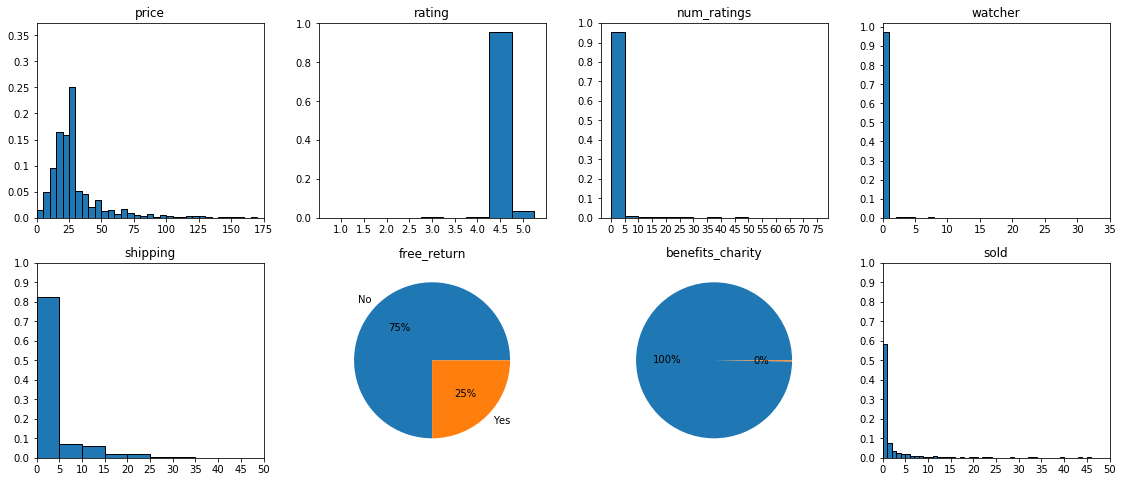

In [7]:
fig, ax = plt.subplots(2,4, figsize=(16,7)); fig.tight_layout(pad=2.4)
a = ax[0,0]
a.hist(price, edgecolor="k", bins = range(0, 185, 5))
a.set_xlim(0, price.quantile(.99))
a.set_xticks(range(0, 180, 25))
a.set_xticklabels(range(0, 180, 25))
range_y = range(0, price.count(), price.count()//20)
a.set_yticks(range_y)
a.set_yticklabels([round(y/price.count(),2) for y in range_y])
a.set_ylim(0, 800)
a.set_title('price')

a = ax[0,1]
a.hist(rating, align='left',edgecolor='k', bins = np.linspace(0.5, 5.5, 11))
a.set_xticks(np.linspace(1,5.5,10)[:-1])
a.set_xlim(.5,5.5)
range_y = range(0, rating.count(), rating.count()//5)
a.set_yticks(range_y)
a.set_yticklabels([round(y/rating.count(),2) for y in range_y])
# a.set_ylim(0,600)
a.set_title('rating')

a = ax[0,2]
a.hist(num_ratings, edgecolor='k', bins = np.linspace(0, 75, 16))
a.set_xticks(np.linspace(0, 75, 16))
# a.set_xlim(-1,35)
range_y = range(0, num_ratings.count(), num_ratings.count()//10)
a.set_yticks(range_y)
a.set_yticklabels([round(y/num_ratings.count(),2) for y in range_y])
# a.set_ylim(0, 200)
a.set_title('num_ratings')

a = ax[0,3]
a.hist(watcher, edgecolor='k',bins = np.linspace(0,35,36))
range_y = range(0, watcher.count(), watcher.count()//10)
a.set_xlim(0, 35)
a.set_xticks(np.linspace(0,35,8))
a.set_yticks(range_y)
a.set_yticklabels([round(y/watcher.count(),2) for y in range_y])
# a.set_ylim(0, 6000)
a.set_title('watcher');

a = ax[1,0]
a.hist(shipping, edgecolor = 'k', bins = np.linspace(0, 50, 11))
a.set_xticks(np.linspace(0, 50, 11))
a.set_xlim(0, 50)
range_y = range(0, shipping.count(), shipping.count()//10)
a.set_yticks(range_y)
a.set_yticklabels([round(y/shipping.count(),2) for y in range_y])
# a.set_ylim(0, 4000)
a.set_title('shipping');

def draw_pie(axis, input, title, labels=['No', 'Yes']):
    a = ax[axis]
    a.pie(input, labels = labels, autopct = '%1.0f%%')
    a.set_title(title)
    
draw_pie((1,1), [sum(free_return == 0), sum(free_return == 1)], 'free_return')
draw_pie((1,2), [sum(benefits_charity == 0), sum(benefits_charity == 1)], 'benefits_charity', None)

a = ax[1,3]
a.hist(sold, edgecolor = 'k', bins = np.linspace(0, 1000, 1001))
a.set_xticks(np.linspace(0, 1000, 201))
a.set_xlim(0, 50)
range_y = range(0, sold.count(), sold.count()//10)
a.set_yticks(range_y)
a.set_yticklabels([round(y/sold.count(),2) for y in range_y])
a.set_title('sold')
# a.set_ylim(0, 3000);

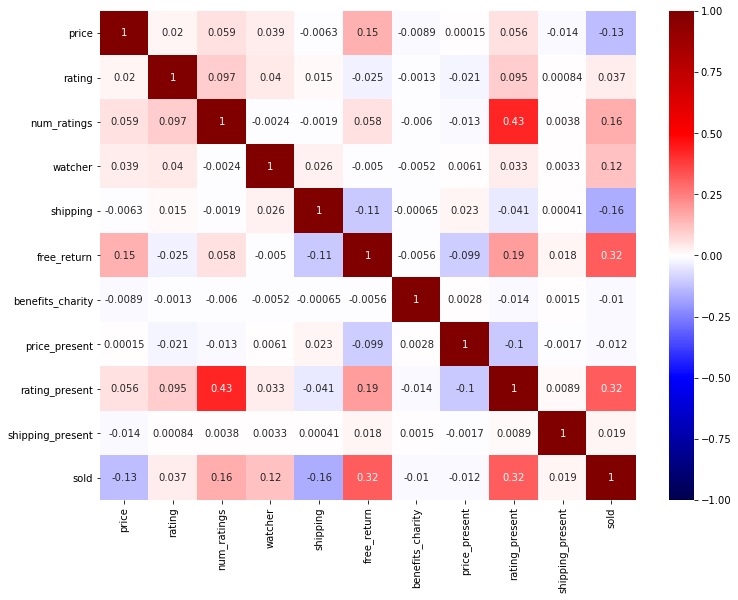

In [8]:
plt.figure(figsize=(12,9))
sns.heatmap(pd.concat([x_train, np.log(y_train+1)], axis = 1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [9]:
log_y = np.log(y_train + 1)
mreg = smf.ols(formula = 'log_y ~ x_train', data = x_train, missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     67.42
Date:                Tue, 14 Jul 2020   Prob (F-statistic):          9.07e-120
Time:                        01:10:05   Log-Likelihood:                -4208.6
No. Observations:                2157   AIC:                             8439.
Df Residuals:                    2146   BIC:                             8502.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8383      1.651     -1.114      0.266      -5.076       1.399
x_train[0]    -0.0107      0.001    -10.227      0.000      -0.013      -0.009
x_train[1]     0.1942      0.202      0.964      0.335      -0.201       0.590
x_train[2]     0.0026      0.001      2.237      0.025       0.000       0.005
x_train[3]     0.0697      0.011      6.588      0.000       0.049       0.090
x_train[4]    -0.0370      0.006     -6.470      0.000      -0.048      -0.026
x_train[5]     1.3128      0.088     14.872      0.000       1.140       1.486
x_train[6]    -0.2381      0.764     -0.312      0.755      -1.737       1.261
x_train[7]     1.5854      0.653      2.430      0.015       0.306       2.865
x_train[8]     1.7963      0.155     11.626      0.000       1.493       2.099
x_train[9]     0.5504      1.208      0.456      0.649      -1.818       2.919
==============================================================================
Omnibus:                      613.452   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1508.114
Skew:                           1.550   Prob(JB):                         0.00
Kurtosis:                       5.677   Cond. No.                     2.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 1. sold vs price

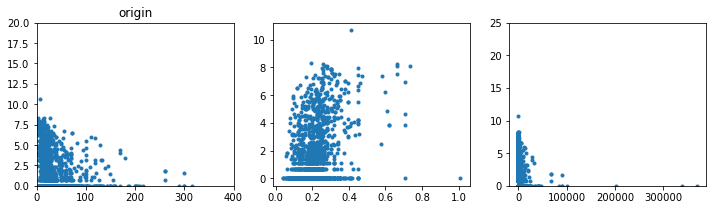

In [10]:
fig, ax = plt.subplots(1,3, figsize = (12, 3))
ax[0].scatter(price, np.log(sold+1), marker = '.'); ax[0].set_xlim(0, 400); ax[0].set_ylim(0, 20); ax[0].set_title('origin')
ax[1].scatter(1/np.sqrt(price), np.log(sold+1), marker = '.');
ax[2].scatter(price**2, np.log(sold+1), marker = '.'); ax[2].set_ylim(0, 4000); ax[2].set_ylim(0, 25);

In [11]:
X, y = 1/np.sqrt(price), np.log(sold+1)
mreg = smf.ols(formula = 'y ~ X', data = pd.concat([X, y], axis = 1), missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     263.9
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           4.57e-56
Time:                        01:10:06   Log-Likelihood:                -4378.6
No. Observations:                2157   AIC:                             8761.
Df Residuals:                    2155   BIC:                             8773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5796      0.118     -4.919      0.000      -0.811      -0.349
X              8.6610      0.533     16.244      0.000       7.615       9.707
==============================================================================
Omnibus:                      499.253   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              958.262
Skew:                           1.402   Prob(JB):                    8.24e-209
Kurtosis:                       4.674   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2. sold vs rating

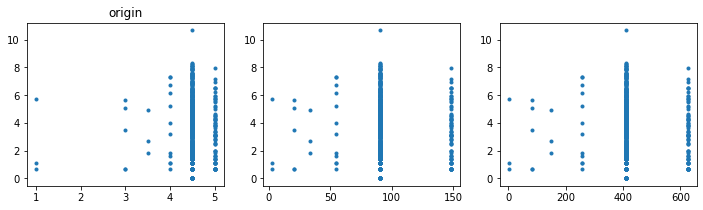

In [12]:
fig, ax = plt.subplots(1,3, figsize = (12,3))
ax[0].scatter(rating, np.log(sold+1), marker = '.'); ax[0].set_title('origin')
ax[1].scatter(np.exp(rating), np.log(sold+1), marker = '.')
ax[2].scatter(rating**4, np.log(sold+1), marker = '.')

In [13]:
X, y = np.exp(rating), np.log(sold+1)
mreg = smf.ols(formula = 'y ~ X', data = pd.concat([X, y], axis = 1), missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     36.55
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.75e-09
Time:                        01:10:06   Log-Likelihood:                -4485.1
No. Observations:                2157   AIC:                             8974.
Df Residuals:                    2155   BIC:                             8985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6524      0.313     -2.084      0.037      -1.266      -0.039
X              0.0205      0.003      6.046      0.000       0.014       0.027
==============================================================================
Omnibus:                      650.633   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1481.409
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       5.150   Cond. No.                         693.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 3. sold vs num_ratings

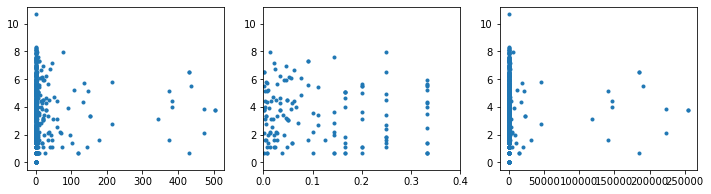

In [14]:
fig, ax = plt.subplots(1,3, figsize = (12, 3))
ax[0].scatter(num_ratings, np.log(sold+1), marker = '.')
ax[1].scatter(1/(num_ratings+1), np.log(sold+1), marker = '.'); ax[1].set_xlim(0, 0.4)
ax[2].scatter(num_ratings**2, np.log(sold+1), marker = '.');

In [15]:
X, y = 1/(num_ratings+1), np.log(sold+1)
mreg = smf.ols(formula = 'y ~ X', data = pd.concat([X, y], axis = 1), missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     234.8
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           2.16e-50
Time:                        01:10:07   Log-Likelihood:                -4391.6
No. Observations:                2157   AIC:                             8787.
Df Residuals:                    2155   BIC:                             8799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8016      0.173     21.980      0.000       3.462       4.141
X             -2.7406      0.179    -15.324      0.000      -3.091      -2.390
==============================================================================
Omnibus:                      714.816   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1846.251
Skew:                           1.808   Prob(JB):                         0.00
Kurtosis:                       5.732   Cond. No.                         8.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 4. sold vs. watcher

In [16]:
sold.value_counts().sort_index()

0        1255
1         168
2          74
3          57
4          38
         ... 
3413        1
3852        1
3951        1
4109        1
43701       1
Name: sold, Length: 244, dtype: int64

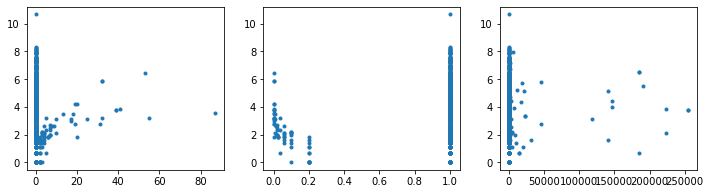

In [17]:
fig, ax = plt.subplots(1,3, figsize = (12, 3))
ax[0].scatter(watcher, np.log(sold+1), marker = '.')
ax[1].scatter(1/(watcher**2+1), np.log(sold+1), marker = '.')
ax[2].scatter(num_ratings**2, np.log(sold+1), marker = '.')

In [18]:
X, y = watcher, np.log(sold+1)
mreg = smf.ols(formula = 'y ~ X', data = pd.concat([X, y], axis = 1), missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     32.12
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.64e-08
Time:                        01:10:07   Log-Likelihood:                -4487.2
No. Observations:                2157   AIC:                             8978.
Df Residuals:                    2155   BIC:                             8990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1974      0.042     28.527      0.000       1.115       1.280
X              0.0679      0.012      5.668      0.000       0.044       0.091
==============================================================================
Omnibus:                      648.288   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1467.671
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                       5.119   Cond. No.                         3.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 5. sold vs. shipping

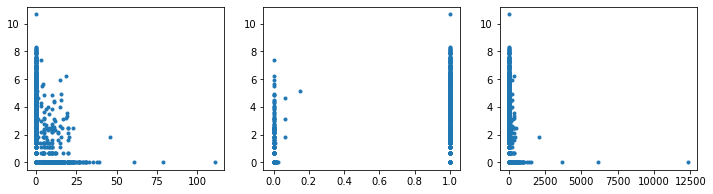

In [19]:
fig, ax = plt.subplots(1,3, figsize = (12, 3))
ax[0].scatter(shipping, np.log(sold+1), marker = '.')
ax[1].scatter(1/(shipping+1)**4, np.log(sold+1), marker = '.')
ax[2].scatter(shipping**2, np.log(sold+1), marker = '.');

In [20]:
X, y = 1/(shipping+1), np.log(sold+1)
mreg = smf.ols(formula = 'y ~ X', data = pd.concat([X, y], axis = 1), missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     71.96
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           4.02e-17
Time:                        01:10:07   Log-Likelihood:                -4467.8
No. Observations:                2157   AIC:                             8940.
Df Residuals:                    2155   BIC:                             8951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4508      0.100      4.510      0.000       0.255       0.647
X              0.9541      0.112      8.483      0.000       0.734       1.175
==============================================================================
Omnibus:                      581.313   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1202.492
Skew:                           1.595   Prob(JB):                    7.62e-262
Kurtosis:                       4.788   Cond. No.                         4.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Transform the features into the x_train

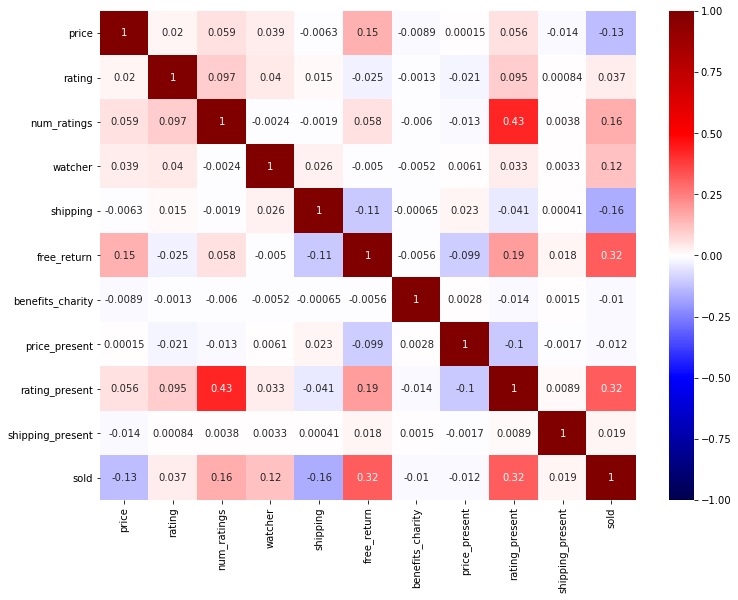

In [21]:
plt.figure(figsize=(12,9))
sns.heatmap(pd.concat([x_train, np.log(y_train+1)], axis = 1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [22]:
log_y = np.log(y_train+1);
mreg = smf.ols(formula = 'log_y ~ x_train', data = x_train, missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     67.42
Date:                Tue, 14 Jul 2020   Prob (F-statistic):          9.07e-120
Time:                        01:10:08   Log-Likelihood:                -4208.6
No. Observations:                2157   AIC:                             8439.
Df Residuals:                    2146   BIC:                             8502.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8383      1.651     -1.114      0.266      -5.076       1.399
x_train[0]    -0.0107      0.001    -10.227      0.000      -0.013      -0.009
x_train[1]     0.1942      0.202      0.964      0.335      -0.201       0.590
x_train[2]     0.0026      0.001      2.237      0.025       0.000       0.005
x_train[3]     0.0697      0.011      6.588      0.000       0.049       0.090
x_train[4]    -0.0370      0.006     -6.470      0.000      -0.048      -0.026
x_train[5]     1.3128      0.088     14.872      0.000       1.140       1.486
x_train[6]    -0.2381      0.764     -0.312      0.755      -1.737       1.261
x_train[7]     1.5854      0.653      2.430      0.015       0.306       2.865
x_train[8]     1.7963      0.155     11.626      0.000       1.493       2.099
x_train[9]     0.5504      1.208      0.456      0.649      -1.818       2.919
==============================================================================
Omnibus:                      613.452   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1508.114
Skew:                           1.550   Prob(JB):                         0.00
Kurtosis:                       5.677   Cond. No.                     2.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
pre_x_train = x_train

x_train.loc[:,['price', 'rating', 'num_ratings', 'watcher', 'shipping']] = \
pd.concat([1/np.sqrt(price), np.exp(rating), 1/(num_ratings + 1), watcher, 1/(shipping + 1)], axis =1)

price, rating, num_ratings, watcher, shipping = \
x_train.price, x_train.rating, x_train.num_ratings, x_train.watcher, x_train.shipping 

In [24]:
log_y = np.log(y_train+1);
mreg = smf.ols(formula = 'log_y ~ x_train', data = x_train, missing = 'drop').fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     130.9
Date:                Tue, 14 Jul 2020   Prob (F-statistic):          1.32e-213
Time:                        01:10:08   Log-Likelihood:                -3989.5
No. Observations:                2157   AIC:                             8001.
Df Residuals:                    2146   BIC:                             8064.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3032      1.301     -1.770      0.077      -4.854       0.248
x_train[0]    11.0866      0.459     24.135      0.000      10.186      11.987
x_train[1]     0.0038      0.003      1.276      0.202      -0.002       0.010
x_train[2]    -1.4538      0.353     -4.123      0.000      -2.145      -0.762
x_train[3]     0.0780      0.010      8.150      0.000       0.059       0.097
x_train[4]     1.2148      0.093     13.054      0.000       1.032       1.397
x_train[5]     1.3066      0.079     16.525      0.000       1.152       1.462
x_train[6]    -0.1934      0.691     -0.280      0.779      -1.548       1.161
x_train[7]     1.4624      0.590      2.480      0.013       0.306       2.619
x_train[8]     0.7806      0.306      2.549      0.011       0.180       1.381
x_train[9]    -0.6226      1.093     -0.570      0.569      -2.766       1.521
==============================================================================
Omnibus:                      465.465   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1099.143
Skew:                           1.187   Prob(JB):                    2.11e-239
Kurtosis:                       5.567   Cond. No.                     4.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interaction effects

In [25]:
log_y = np.log(y_train+1); X = x_train
mreg = smf.ols(formula = 'log_y ~ X', data = X, missing = 'drop').fit()
def plot_interaction(var1, var2, xlim = None):
    log_y = np.log(y_train+1)
    fig, ax = plt.subplots(figsize=(50, 5))
    interaction_plot(x = var1, trace = var2, response = log_y, colors=['red','blue'], ax=ax)
    if xlim:
        plt.xlim(xlim)

    X = pd.concat([x_train, (var1 * var2)], axis =1)
    m = smf.ols(formula = 'log_y ~ X', data = X, missing = 'drop').fit()
    plt.show()
    df = pd.concat([pd.DataFrame(mreg.params), pd.DataFrame(m.params)], axis=1)
    print(df)
    print(f"\npre.rsquared: {mreg.rsquared}")
    print(f"pre.rsquared_adj: {mreg.rsquared_adj}\n")
    print(f"post.rsquared: {m.rsquared}")
    print(f"post.rsquared_adj: {m.rsquared_adj}")

price * free_return

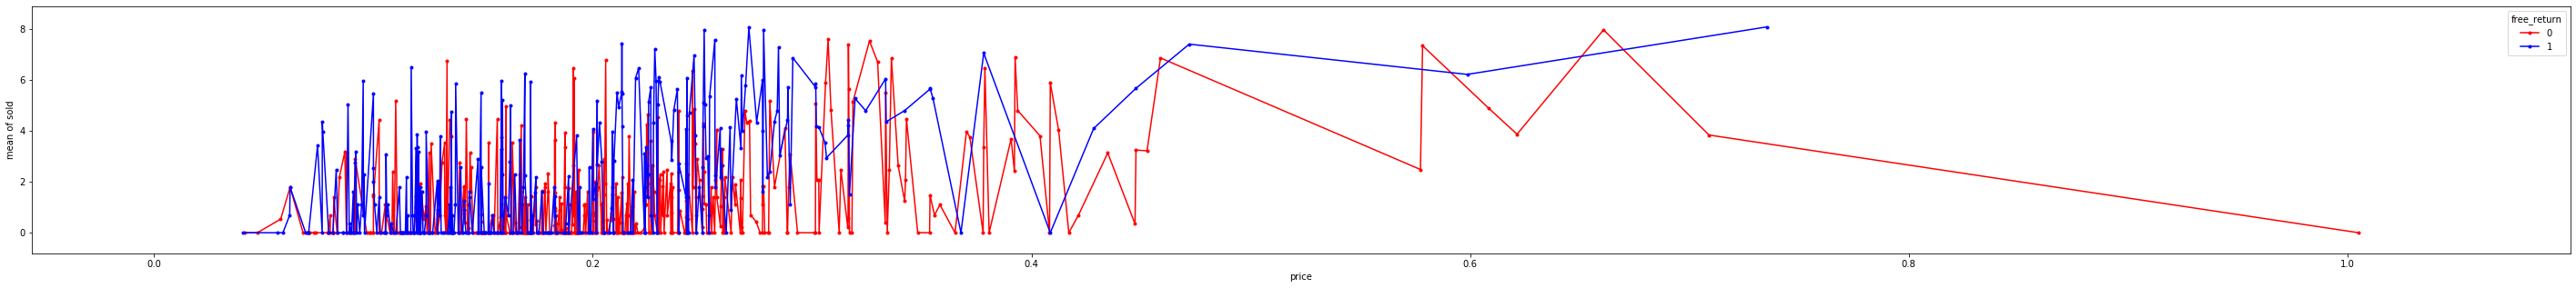

                   0         0
Intercept  -2.303215 -1.908360
X[0]       11.086556  8.847226
X[1]        0.003842  0.004509
X[2]       -1.453772 -1.445347
X[3]        0.078018  0.077705
X[4]        1.214823  1.138400
X[5]        1.306551 -0.245735
X[6]       -0.193434 -0.311761
X[7]        1.462390  1.344432
X[8]        0.780648  0.821384
X[9]       -0.622617 -0.434813
X[10]            NaN  7.728618

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3960066123918443
post.rsquared_adj: 0.3929092104041102


In [26]:
plot_interaction(price, free_return)
# When the item is expensive, higher price has weaker effect on sale rate when it's free return.

price * benefits_charity

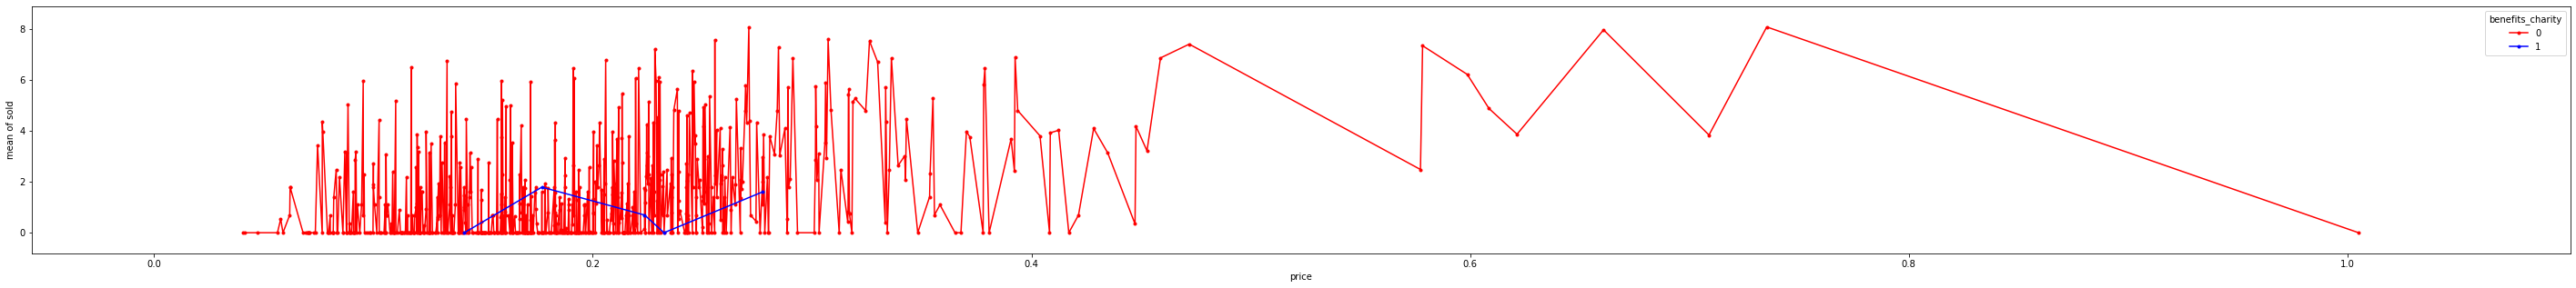

                   0          0
Intercept  -2.303215  -2.305870
X[0]       11.086556  11.099136
X[1]        0.003842   0.003846
X[2]       -1.453772  -1.454311
X[3]        0.078018   0.078035
X[4]        1.214823   1.214558
X[5]        1.306551   1.308946
X[6]       -0.193434   2.443782
X[7]        1.462390   1.463445
X[8]        0.780648   0.779592
X[9]       -0.622617  -0.623837
X[10]            NaN -12.534511

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3791158756026761
post.rsquared_adj: 0.3759318544519207


In [27]:
plot_interaction(price, benefits_charity)
# When the item profit is for charity, the sale rate is consistently low and
# it doesn't matter if it's highly expensive or not.

rating * free_return

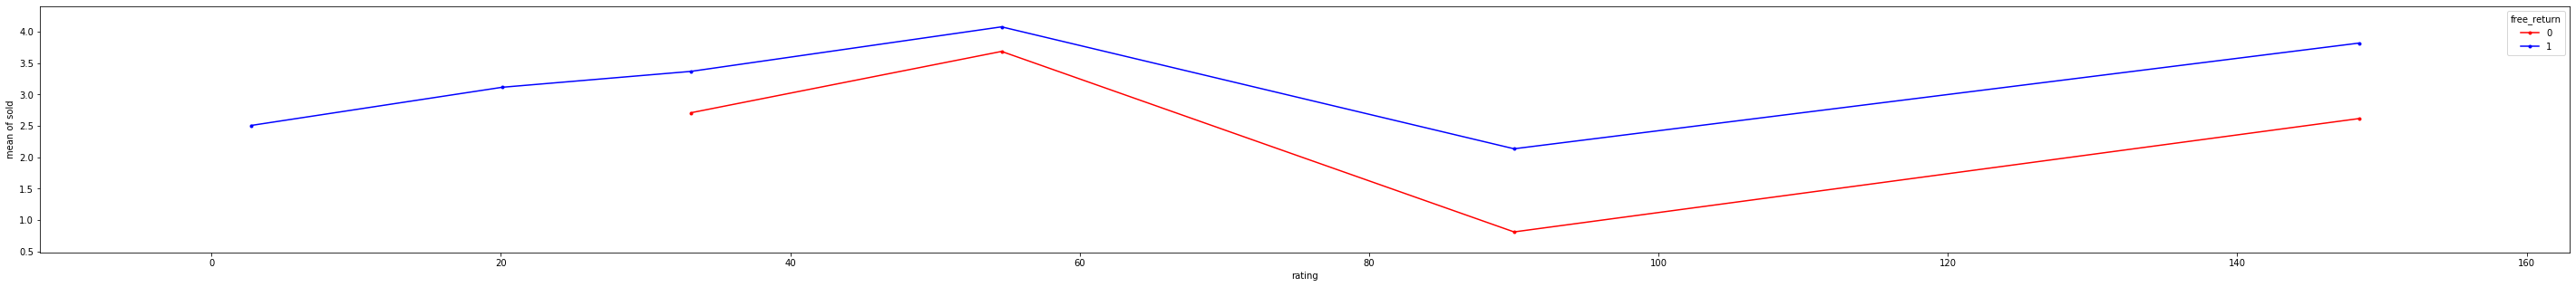

                   0          0
Intercept  -2.303215  -2.261972
X[0]       11.086556  11.087303
X[1]        0.003842   0.003256
X[2]       -1.453772  -1.444782
X[3]        0.078018   0.077953
X[4]        1.214823   1.214507
X[5]        1.306551   1.224477
X[6]       -0.193434  -0.193508
X[7]        1.462390   1.464844
X[8]        0.780648   0.791084
X[9]       -0.622617  -0.622038
X[10]            NaN   0.000890

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3789119349308422
post.rsquared_adj: 0.3757268679304876


In [28]:
plot_interaction(rating, free_return)

rating * benefits_charity

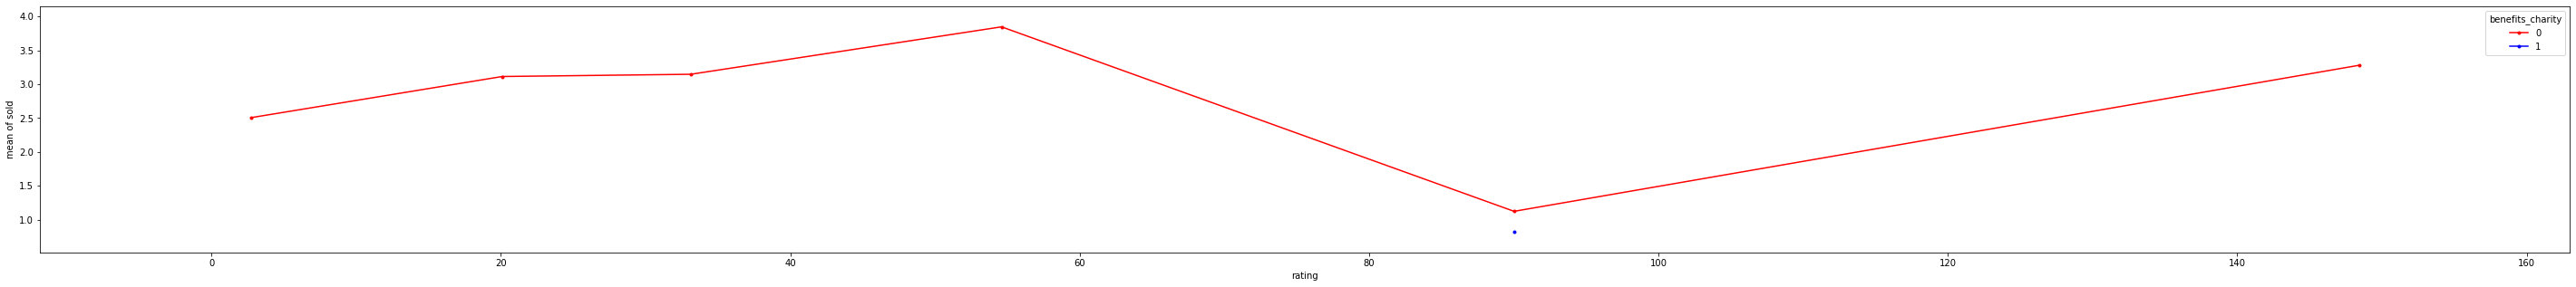

                   0          0
Intercept  -2.303215  -2.303215
X[0]       11.086556  11.086556
X[1]        0.003842   0.003842
X[2]       -1.453772  -1.453772
X[3]        0.078018   0.078018
X[4]        1.214823   1.214823
X[5]        1.306551   1.306551
X[6]       -0.193434  -0.000024
X[7]        1.462390   1.462390
X[8]        0.780648   0.780648
X[9]       -0.622617  -0.622617
X[10]            NaN  -0.002149

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3789048796328214
post.rsquared_adj: 0.37601068056307685


In [29]:
plot_interaction(rating, benefits_charity)

# Too little data for benefits charity to make a judgement call.

num_ratings * free_return

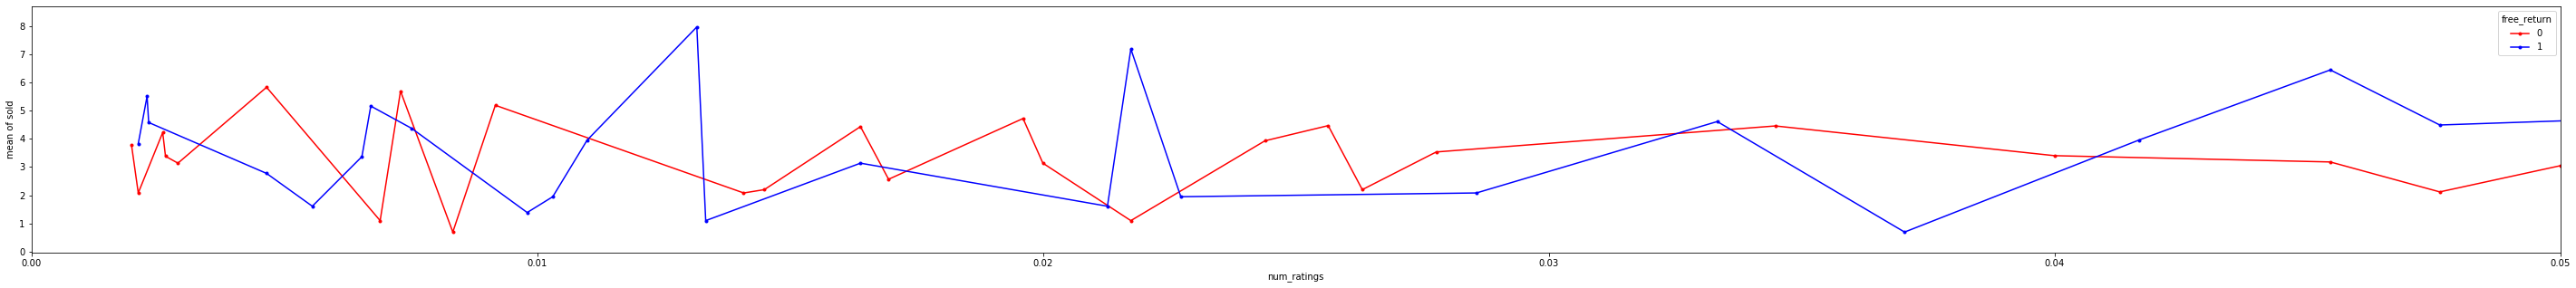

                   0          0
Intercept  -2.303215  -2.083319
X[0]       11.086556  11.076887
X[1]        0.003842   0.003949
X[2]       -1.453772  -1.612370
X[3]        0.078018   0.078417
X[4]        1.214823   1.217529
X[5]        1.306551   0.993769
X[6]       -0.193434  -0.192507
X[7]        1.462390   1.392021
X[8]        0.780648   0.777040
X[9]       -0.622617  -0.629645
X[10]            NaN   0.339316

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.37926553640162797
post.rsquared_adj: 0.37608228274214917


In [30]:
plot_interaction(num_ratings, free_return,(0,0.05))

# The number of ratings does not seem to have particular effect on sale rate when it's free return.

num_ratings * benefits_charity

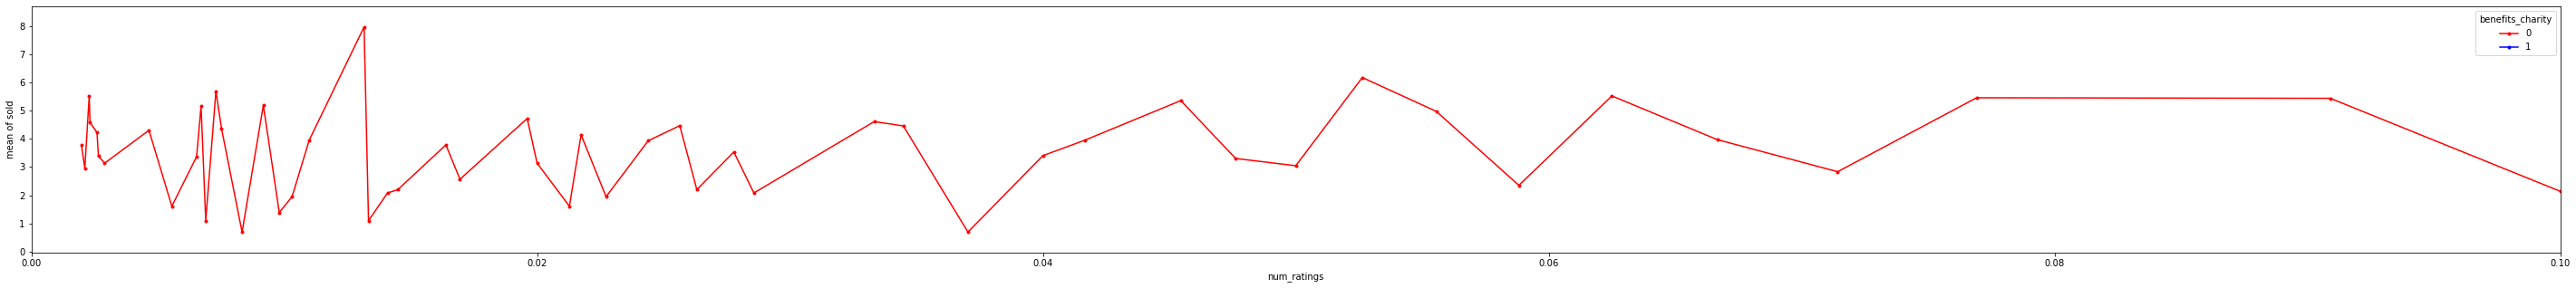

                   0          0
Intercept  -2.303215  -2.303215
X[0]       11.086556  11.086556
X[1]        0.003842   0.003842
X[2]       -1.453772  -1.453772
X[3]        0.078018   0.078018
X[4]        1.214823   1.214823
X[5]        1.306551   1.306551
X[6]       -0.193434  -0.096717
X[7]        1.462390   1.462390
X[8]        0.780648   0.780648
X[9]       -0.622617  -0.622617
X[10]            NaN  -0.096717

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3789048796328214
post.rsquared_adj: 0.37601068056307685


In [31]:
plot_interaction(num_ratings, benefits_charity,(0,0.1))
# Not too much data but seems like interaction exists.

watcher * free_return

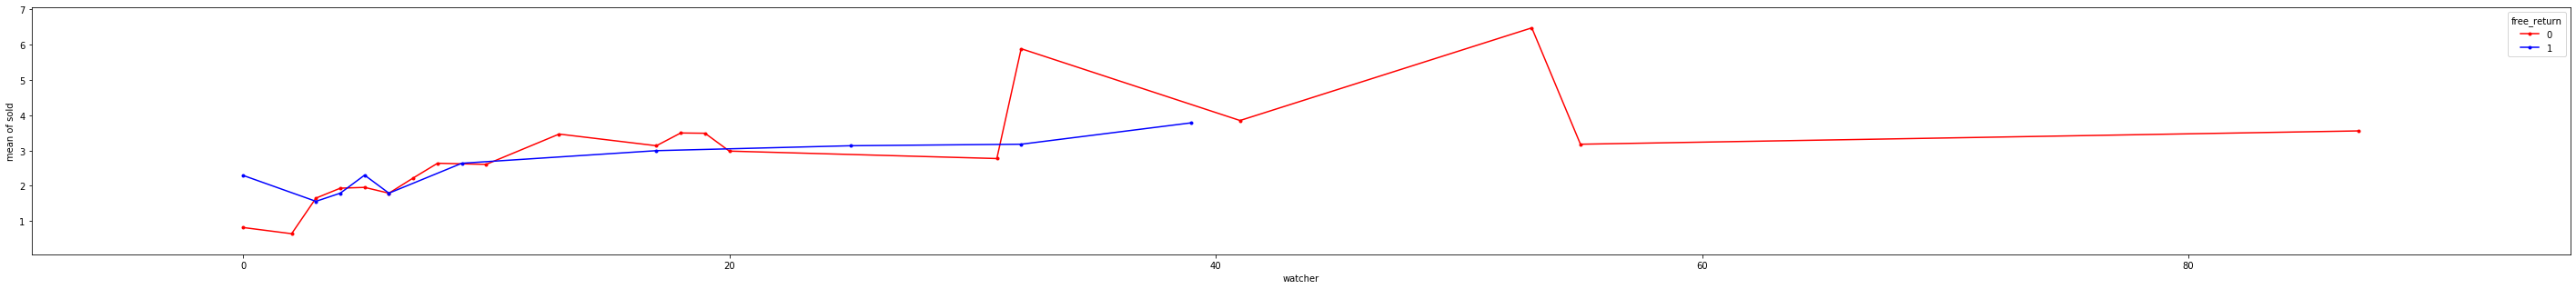

                   0          0
Intercept  -2.303215  -2.406157
X[0]       11.086556  11.078224
X[1]        0.003842   0.004774
X[2]       -1.453772  -1.470208
X[3]        0.078018   0.092852
X[4]        1.214823   1.220734
X[5]        1.306551   1.330237
X[6]       -0.193434  -0.190933
X[7]        1.462390   1.497370
X[8]        0.780648   0.782637
X[9]       -0.622617  -0.632433
X[10]            NaN  -0.077344

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.38184569489696696
post.rsquared_adj: 0.37867567281951553


In [32]:
plot_interaction(watcher, free_return)

watcher * benefits_charity

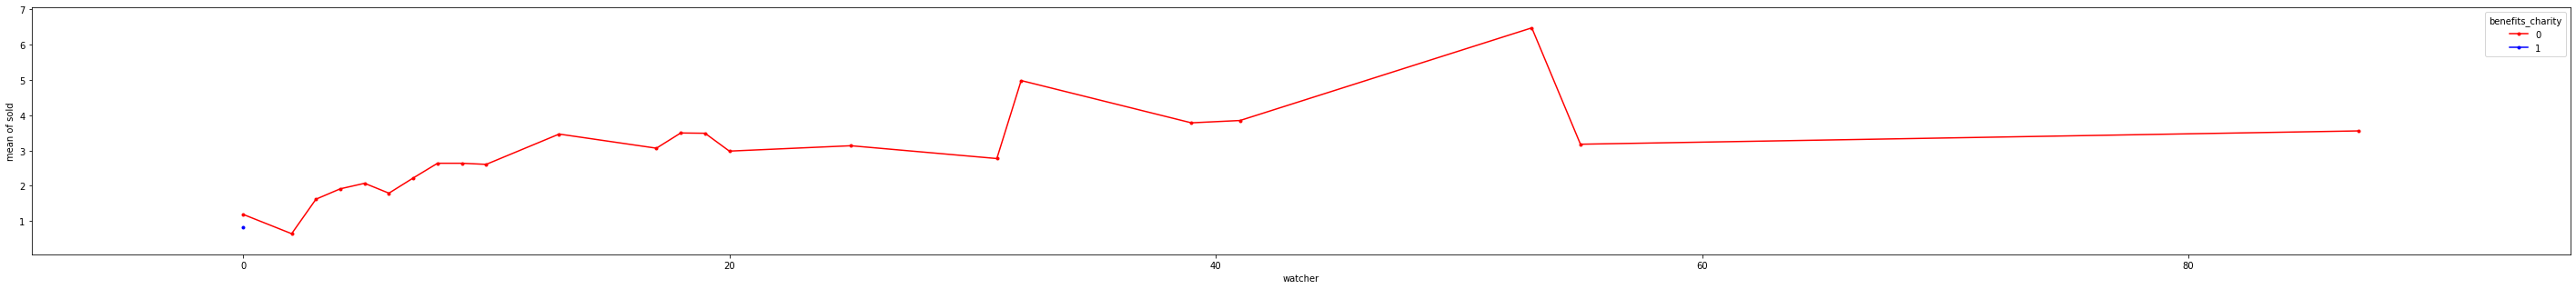

                   0          0
Intercept  -2.303215  -2.303215
X[0]       11.086556  11.086556
X[1]        0.003842   0.003842
X[2]       -1.453772  -1.453772
X[3]        0.078018   0.078018
X[4]        1.214823   1.214823
X[5]        1.306551   1.306551
X[6]       -0.193434  -0.193434
X[7]        1.462390   1.462390
X[8]        0.780648   0.780648
X[9]       -0.622617  -0.622617
X[10]            NaN   0.000000

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3789048796328214
post.rsquared_adj: 0.37601068056307685


In [33]:
plot_interaction(watcher, benefits_charity)

shipping * free_return

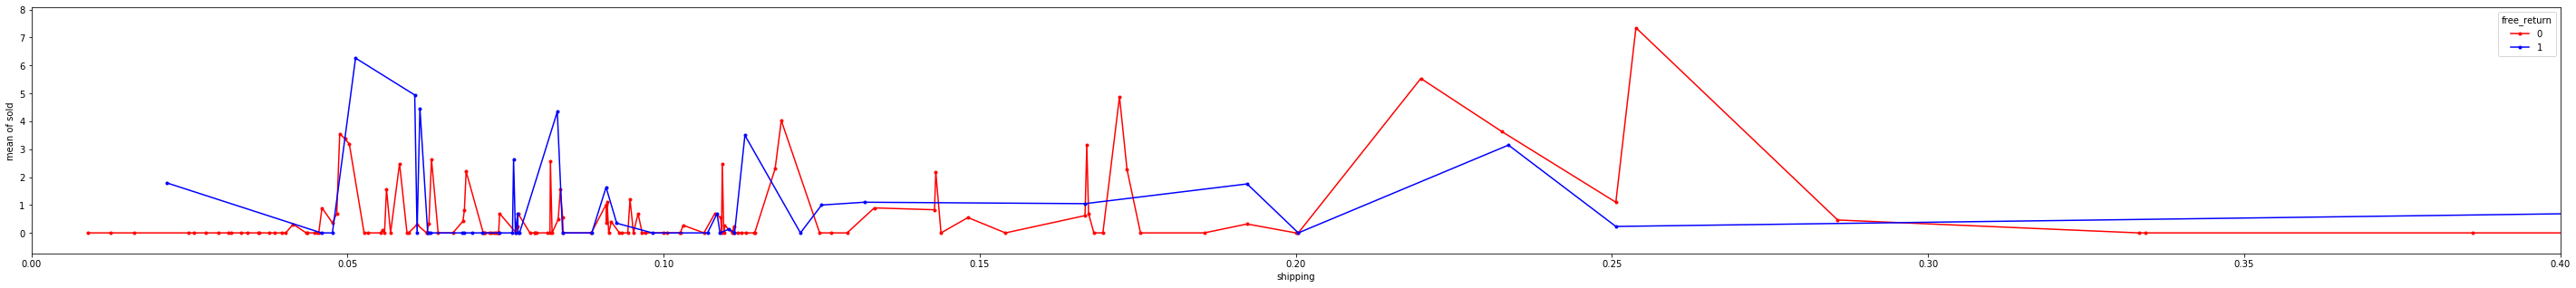

                   0          0
Intercept  -2.303215  -2.316329
X[0]       11.086556  11.030259
X[1]        0.003842   0.003861
X[2]       -1.453772  -1.450401
X[3]        0.078018   0.077602
X[4]        1.214823   1.137575
X[5]        1.306551   0.935886
X[6]       -0.193434  -0.204363
X[7]        1.462390   1.500580
X[8]        0.780648   0.767735
X[9]       -0.622617  -0.579204
X[10]            NaN   0.431162

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.379831551737868
post.rsquared_adj: 0.3766512007211391


In [34]:
plot_interaction(shipping, free_return, (0, 0.4))
# Interaction seems to exist.

shipping * benefits_charity

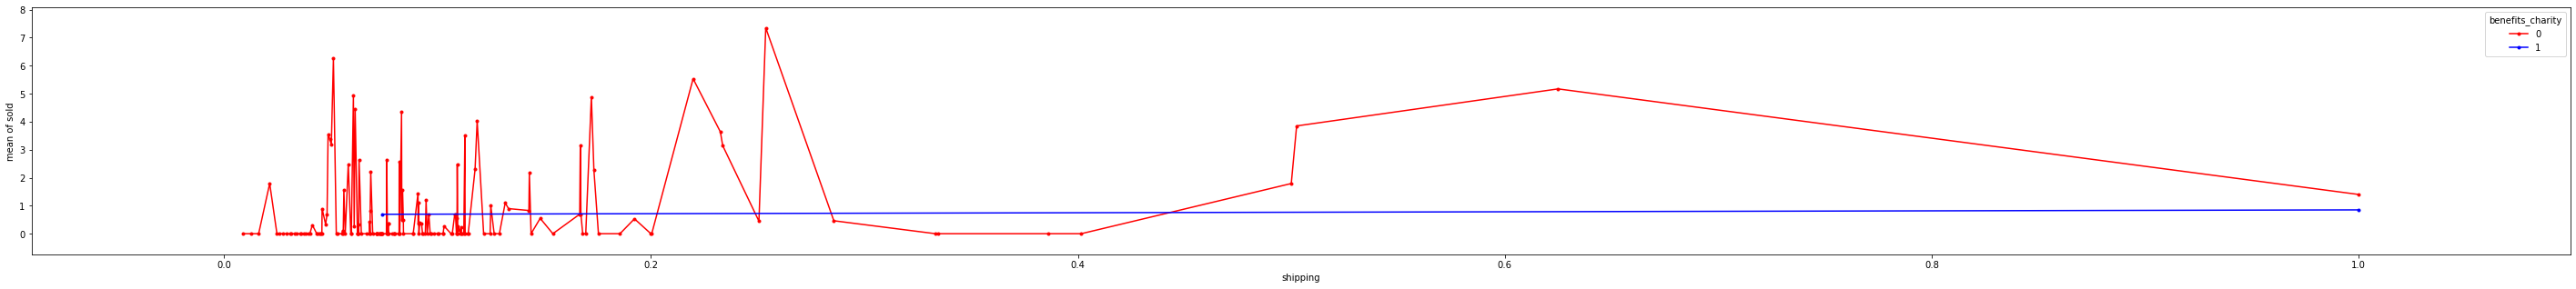

                   0          0
Intercept  -2.303215  -2.305248
X[0]       11.086556  11.088564
X[1]        0.003842   0.003844
X[2]       -1.453772  -1.453648
X[3]        0.078018   0.078026
X[4]        1.214823   1.217711
X[5]        1.306551   1.306902
X[6]       -0.193434   0.786114
X[7]        1.462390   1.462996
X[8]        0.780648   0.780452
X[9]       -0.622617  -0.624327
X[10]            NaN  -1.202198

pre.rsquared: 0.3789048796328215
pre.rsquared_adj: 0.37601068056307696

post.rsquared: 0.3790252141857029
post.rsquared_adj: 0.3758407281046039


In [35]:
plot_interaction(shipping, benefits_charity)

In [36]:
y = np.log(sold+1)
X = x_train
formula = \
'y ~ price * free_return' + \
' + price * shipping + num_ratings * shipping'

fit = smf.ols(formula = formula, data = pd.concat([X, y], axis=1), missing = 'drop').fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     216.2
Date:                Tue, 14 Jul 2020   Prob (F-statistic):          2.23e-243
Time:                        01:10:11   Log-Likelihood:                -3928.3
No. Observations:                2157   AIC:                             7873.
Df Residuals:                    2149   BIC:                             7918.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.3145      0.473      4.893      0.000       1.387       3.242
price                    0.5112      0.836      0.611      0.541      -1.129       2.152
free_return              0.4831      0.217      2.222      0.026       0.057       0.909
price:free_return        3.9956      1.019      3.923      0.000       1.998       5.993
shipping                -1.7273      0.518     -3.334      0.001      -2.743      -0.711
price:shipping          13.4246      1.077     12.466      0.000      11.313      15.537
num_ratings             -2.3195      0.432     -5.366      0.000      -3.167      -1.472
num_ratings:shipping    -0.1538      0.466     -0.330      0.741      -1.068       0.760
==============================================================================
Omnibus:                      521.924   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1196.024
Skew:                           1.345   Prob(JB):                    1.94e-260
Kurtosis:                       5.465   Cond. No.                         77.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
interaction_cols = \
pd.concat([(price * free_return).rename('price * free_return'),
          (price * shipping).rename('price * shipping'),
          (num_ratings * shipping).rename('num_ratings * shipping')], axis = 1)

x_train = pd.concat([x_train, interaction_cols], axis = 1)

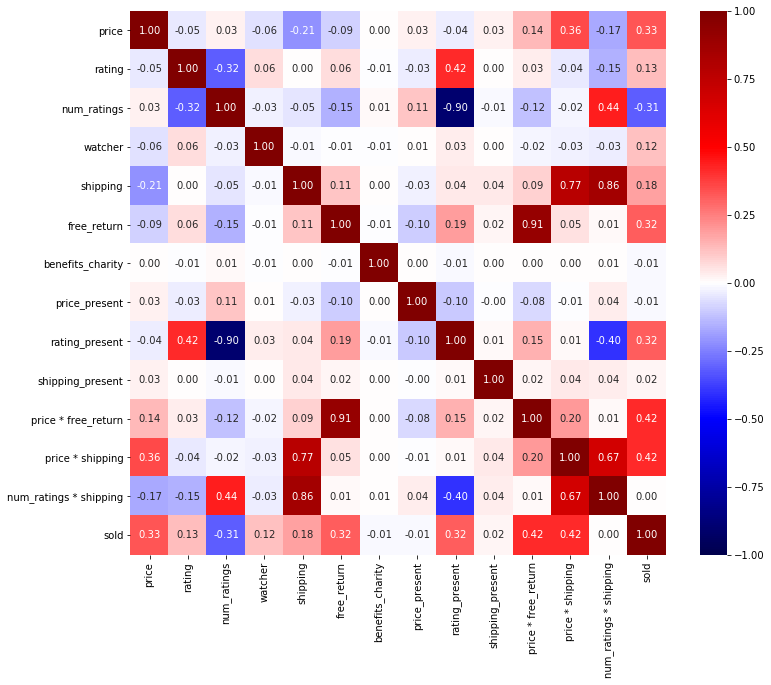

In [38]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.concat([x_train, np.log(y_train+1)], axis = 1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.2f');

In [39]:
pd.to_pickle(x_train, 'x_train.pkl')
pd.to_pickle(x_test, 'x_test.pkl')
pd.to_pickle(y_train, 'y_train.pkl')
pd.to_pickle(y_test, 'y_test.pkl')

In [41]:
sum(df.sold == 0) / len(df)

0.5856586632057106